# Inference

In this notebook, we will use the trained model to generate captions for images in the test dataset.


In [1]:
from PIL import Image
import torch
import math
from torchvision import transforms
from model import EncoderCNN, DecoderRNN
from nlp_utils import clean_sentence
import os
import pickle
import matplotlib.pyplot as plt

import requests
from io import BytesIO
import urllib.parse

In [2]:
HOME: str = os.getenv('HOME') # echo $HOME
USER: str = os.getenv('USER') # echo $USER

print(f"HOME: {HOME} | USER: {USER}")

HOME: /home/farid | USER: farid


In [3]:
if USER=="alijanif":
	WDIR = "/scratch/project_2004072/IMG_Captioning"
	cocoapi_dir = os.path.join(WDIR, "MS_COCO")
	models_dir = os.path.join(WDIR, "trash", "models")
else:
	WDIR = "datasets"
	cocoapi_dir = os.path.join(HOME, WDIR, "MS_COCO")
	models_dir = os.path.join(HOME, WDIR, "trash", "models")

In [4]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

# Set the necessary parameters
embed_size = 256  # Assuming it's the same as during training
hidden_size = 512  # Assuming it's the same as during training
vb_fpth = os.path.join("data", "vocab.pkl")
with open(vb_fpth, "rb") as f:
    vocab = pickle.load(f)

print(type(vocab))

vocab_size = len(vocab)

# Initialize the encoder and decoder.
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Moving models to the appropriate device
encoder.to(device)
decoder.to(device)

Using Device: cuda
<class 'vocabulary.Vocabulary'>


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/farid/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:23<00:00, 4.39MB/s]


DecoderRNN(
  (embed): Embedding(11543, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=11543, bias=True)
)

In [5]:
num_epochs = 30  # training epochs
encoder_fname = f"encoder_{num_epochs}_nEpochs.pkl"
decoder_fname = f"decoder_{num_epochs}_nEpochs.pkl"

print(f"Encoder fpath: {os.path.join(models_dir, encoder_fname)}")
print(f"Decoder fpath: {os.path.join(models_dir, decoder_fname)}")

# Loading the trained weights
encoder.load_state_dict(torch.load(os.path.join(models_dir, encoder_fname)))
decoder.load_state_dict(torch.load(os.path.join(models_dir, decoder_fname)))

# Set models to evaluation mode
encoder.eval()
decoder.eval()

Encoder fpath: /home/farid/datasets/trash/models/encoder_30_nEpochs.pkl
Decoder fpath: /home/farid/datasets/trash/models/decoder_30_nEpochs.pkl


/tmp/ipykernel_109654/2842579883.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(os.path.join(models_dir, encoder_fname)))
/tmp/ipyker

DecoderRNN(
  (embed): Embedding(11543, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=11543, bias=True)
)

In [6]:
tst_img_dir = "TEST_IMGs"

In [7]:
def generate_caption(img_source: str = os.path.join(tst_img_dir, "baseball.jpeg")):
    # Check if the input is a URL or local path
    is_url = urllib.parse.urlparse(img_source).scheme != ""

    if is_url:
        # If it's a URL, download the image
        response = requests.get(img_source)
        test_image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        # If it's a local path, open the image directly
        test_image = Image.open(img_source).convert("RGB")

    print(img_source, type(test_image), is_url)

    # Apply transformations to the test image
    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),
            (0.229, 0.224, 0.225),
        ),
    ])

    # Preprocess the test image
    test_image_tensor = transform_test(test_image).unsqueeze(0)  # Add batch dimension

    # Move the preprocessed image to the appropriate device
    test_image_tensor = test_image_tensor.to(device)

    # Pass the test image through the encoder
    with torch.no_grad():
        features = encoder(test_image_tensor).unsqueeze(1)

    # Generate captions with the decoder
    with torch.no_grad():
        output = decoder.sample(features)

    # Convert the output into a clean sentence
    caption = clean_sentence(output, vocab.idx2word)

    # Display the test image with the generated caption
    plt.imshow(test_image)
    plt.axis('off')
    plt.title(caption)
    plt.show()

TEST_IMGs/6247_107698.jpg <class 'PIL.Image.Image'> False


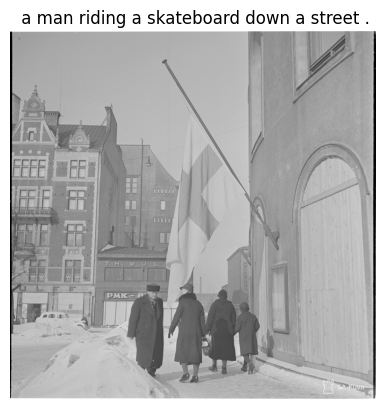

In [8]:
generate_caption( 
  # img_source="https://hips.hearstapps.com/hmg-prod/images/beach-summer-instagram-captions-1621880365.jpg"
  img_source=os.path.join(tst_img_dir, "6247_107698.jpg")
  # img_source=os.path.join(tst_img_dir, "COCO_val2014_000000000328.jpg"),
  # img_source="https://www.thenexttrip.xyz/wp-content/uploads/2022/08/San-Diego-Instagram-Spots-2-820x1025.jpg" # beach lady
  # img_source="https://www.sunnylife.com.au/cdn/shop/articles/Instagram_1068_1024x1024.jpg" # beach lady checking phone
  # img_source="https://d3h7nocoh5wnls.cloudfront.net/medium_65f863d2b8a8f574defc0222_Cowgirl_20_Instagram_20_Captions_20_8_e9b3ef13bc.webp" # standing woman holding rope
  # img_source="https://d3h7nocoh5wnls.cloudfront.net/medium_65f863d2b8a8f574defc058b_One_Word_Joshua_Tree_Captions_0bc104498d.webp"
  # img_source="https://hips.hearstapps.com/hmg-prod/images/beach-summer-instagram-captions-1621880365.jpg" # wonderful result
  # img_source="https://company.finnair.com/resource/image/435612/landscape_ratio16x9/1000/563/76f7e18b20ed1612f80937e91235c1a2/C7D5B60FA1B0EDB0ADB9967772AE17C0/history-1924.jpg"
  # img_source="https://media.istockphoto.com/id/498168409/photo/summer-beach-with-strafish-and-shells.jpg?s=612x612&w=0&k=20&c=_SCAILCSzeekYQQAc94-rlAkj7t_1VmiqOb5DmVo_kE="
  # img_source=os.path.join(tst_img_dir, "baseball.jpeg")
  # img_source=os.path.join(tst_img_dir, "beach_holding_drink.JPG"),
)

In [9]:
def generate_captions(img_sources: list):
    def load_image(img_source):
        is_url = urllib.parse.urlparse(img_source).scheme != ""
        if is_url:
            response = requests.get(img_source)
            return Image.open(BytesIO(response.content)).convert("RGB")
        else:
            return Image.open(img_source).convert("RGB")

    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    captions = []
    images = []

    for img_source in img_sources:
        img = load_image(img_source)
        images.append(img)
        
        img_tensor = transform_test(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            features = encoder(img_tensor).unsqueeze(1)
            output = decoder.sample(features)
        
        caption = clean_sentence(output, vocab.idx2word)
        captions.append(caption)

    # Calculate grid dimensions
    n_images = len(images)
    n_cols = min(5, n_images)
    n_rows = math.ceil(n_images / n_cols)

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    fig.suptitle(f"Generated Captions Epochs: {num_epochs}", fontsize=11)

    for i, (img, caption) in enumerate(zip(images, captions)):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(caption, wrap=True, fontsize=10)

    # Remove empty subplots
    for i in range(n_images, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

    plt.tight_layout()
    plt.show()

In [10]:
IMGs_list = [
  os.path.join(tst_img_dir, "6655_108104.jpg"),
  os.path.join(tst_img_dir, "6199_107650.jpg"),
  os.path.join(tst_img_dir, "enjoying_sun.jpg"),
  os.path.join(tst_img_dir, "6014_107466.jpg"),
  os.path.join(tst_img_dir, "5968_115463.jpg"),
  os.path.join(tst_img_dir, "6170_107622.jpg"),
  os.path.join(tst_img_dir, "6018_107470.jpg"),
  os.path.join(tst_img_dir, "6640_108089.jpg"),
  os.path.join(tst_img_dir, "6653_108102.jpg"),
  "https://company.finnair.com/resource/image/2213452/landscape_ratio16x9/1000/563/2ffba636bc1b8f612d36fcec5c96420a/3FEFB7C5D68C865BC8CEC368B2728C6E/history-1964.jpg",
  "https://company.finnair.com/resource/image/435616/landscape_ratio16x9/1000/563/3e62f054fbb5bb807693d7148286533c/CC6DAD5A4CD3B4D8B3DE10FBEC25073F/history-hero-image.jpg",
  "https://company.finnair.com/resource/image/2213582/landscape_ratio16x9/1000/563/35eb282d3ffb3ebde319d072918c7a1a/717BA40152C49614C8073D1F28A0F1A5/history-1983.jpg",
  "https://www.thenexttrip.xyz/wp-content/uploads/2022/08/San-Diego-Instagram-Spots-2-820x1025.jpg", # beach lady
  "https://www.sunnylife.com.au/cdn/shop/articles/Instagram_1068_1024x1024.jpg", # beach lady checking phone  
  "https://d3h7nocoh5wnls.cloudfront.net/medium_65f863d2b8a8f574defc0222_Cowgirl_20_Instagram_20_Captions_20_8_e9b3ef13bc.webp", # standing woman holding rope
]

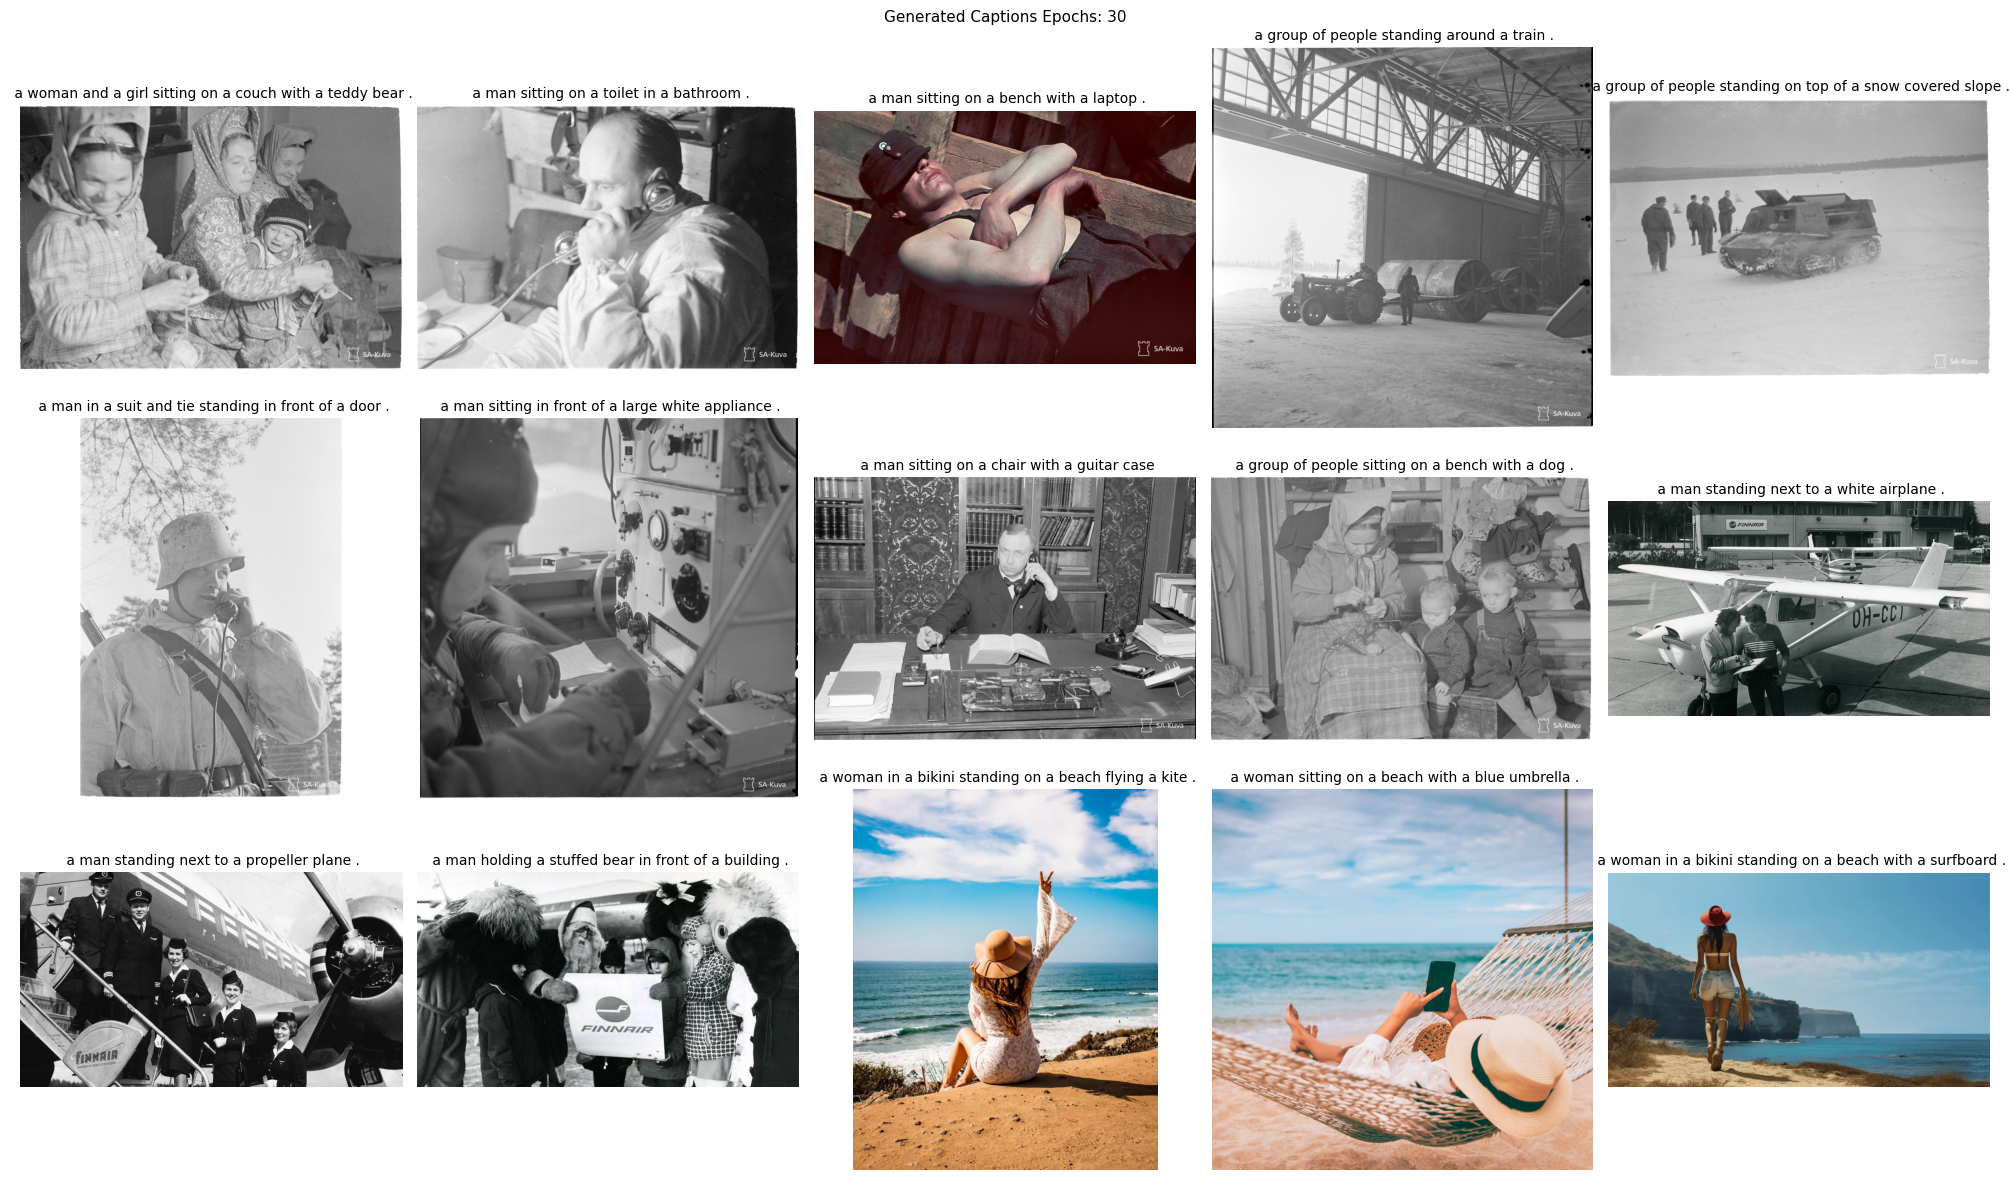

In [11]:
generate_captions(
  img_sources=IMGs_list
)

In [12]:
WAR_IMGs = [
  "https://company.finnair.com/resource/image/2213312/landscape_ratio16x9/1000/563/bcac65735aaebebb4e0c4a23c4bdc16f/E1518AC081A9A95333B9C660BDF7E745/history-1946.jpg",
  os.path.join(tst_img_dir, "skiing.jpg"),
  os.path.join(tst_img_dir, "jet.jpg"),
  os.path.join(tst_img_dir, "smoking_reading.jpg"),
  os.path.join(tst_img_dir, "reindeers.jpg"),
  os.path.join(tst_img_dir, "5919_115414.jpg"),
  "https://company.finnair.com/resource/image/2213440/landscape_ratio16x9/1000/563/483a8f4ab95ff73784cb69d3e365036d/839F4422FA41D5FFC5AC942E7C963944/history-1954.jpg",
  os.path.join(tst_img_dir, "5940_115435.jpg"),
  os.path.join(tst_img_dir, "JSdia040_166042.jpg"),
  os.path.join(tst_img_dir, "JSdia026_165750.jpg"),
  os.path.join(tst_img_dir, "JSdia018_166241.jpg"),
  os.path.join(tst_img_dir, "5919_115414.jpg"),
]

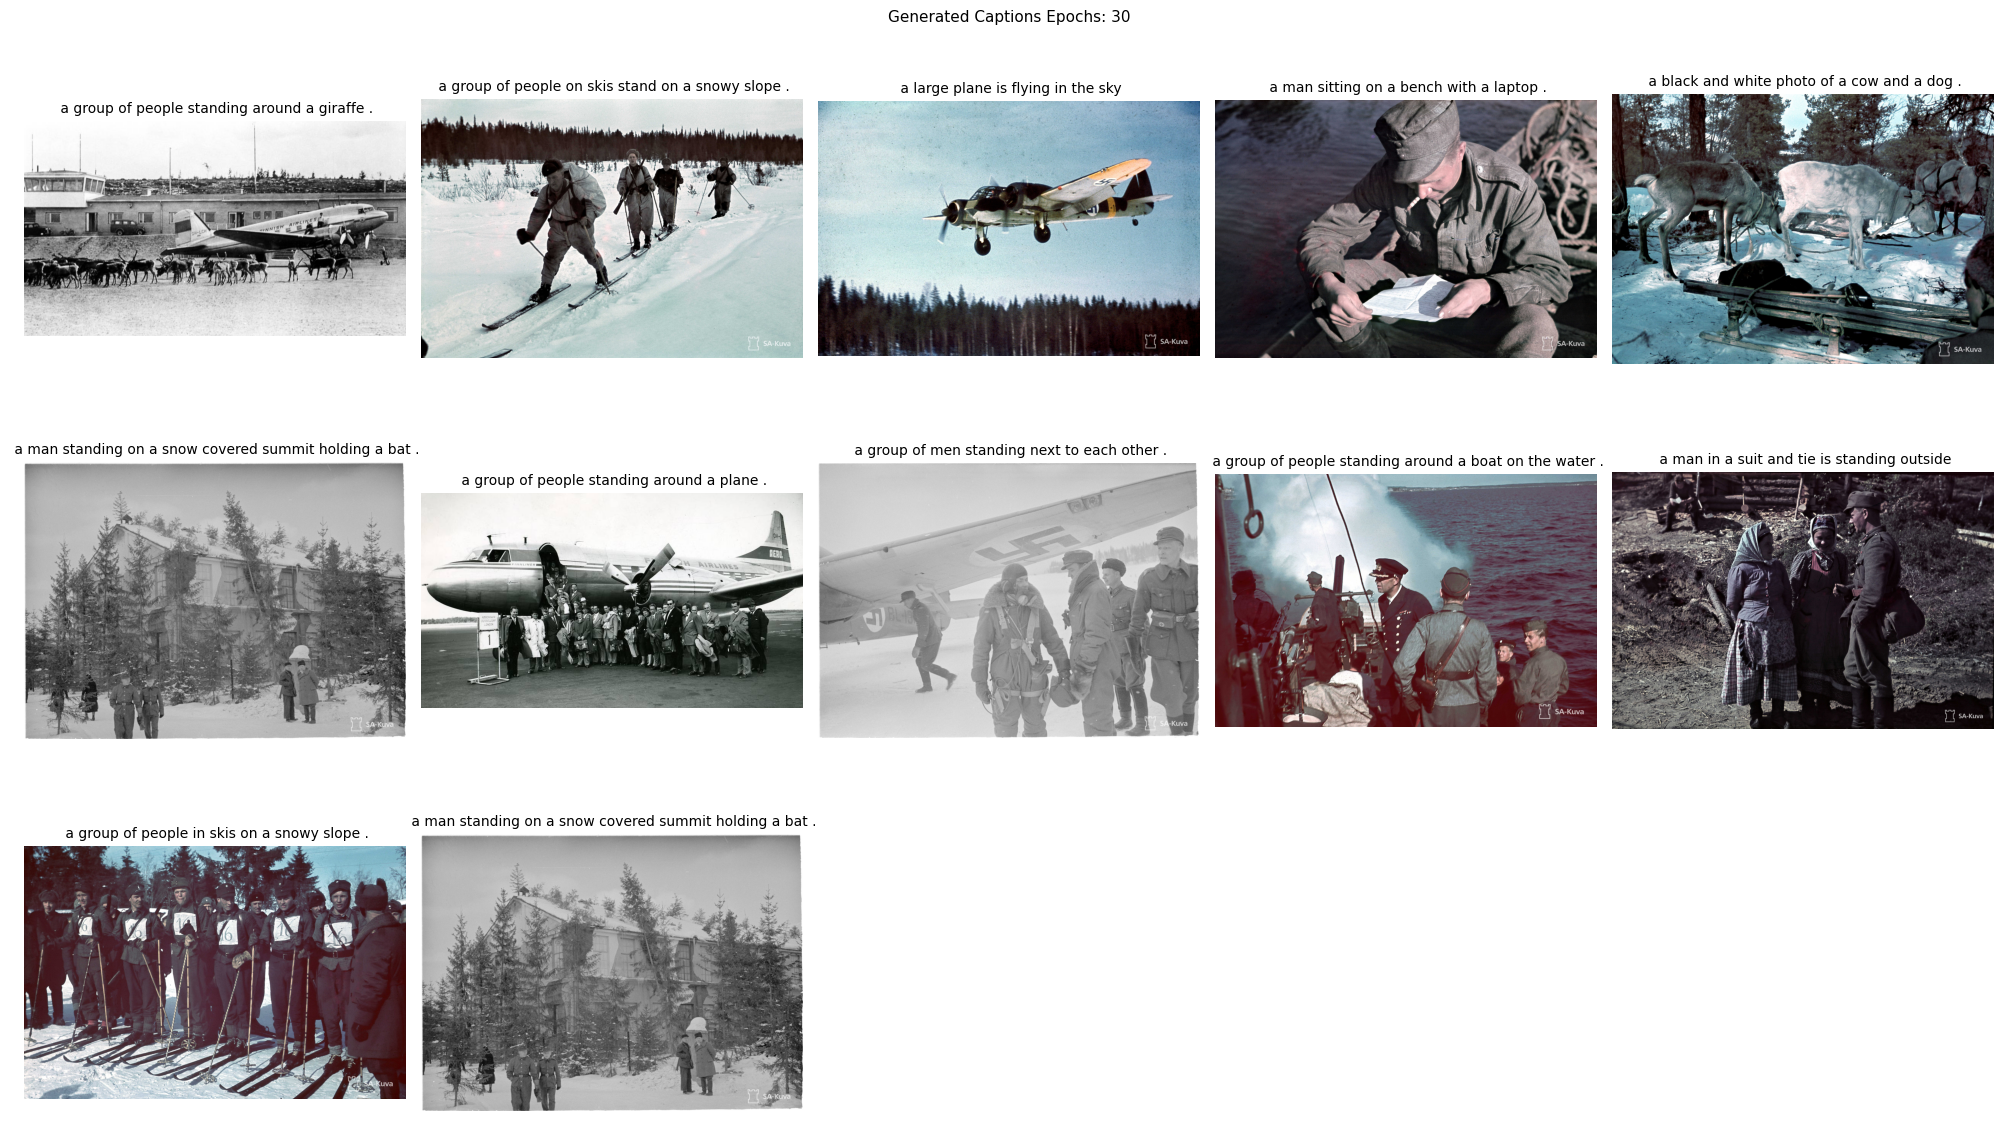

In [13]:
generate_captions(
  img_sources=WAR_IMGs
)